In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if paths are correct by listing files in the directory
import os

# List the contents of the images folder
print("Images in the directory:")
print(os.listdir('/content/drive/MyDrive/MapillaryVistas/training/images'))

# List the contents of the labels folder
print("Labels in the directory:")
print(os.listdir("/content/drive/MyDrive/MapillaryVistas/training/labels"))

# List the contents of the instance folder
print("Instance masks in the directory:")
print(os.listdir("/content/drive/MyDrive/MapillaryVistas/training/instances"))

# List the contents of the panoptic folder
print("Panoptic masks in the directory:")
print(os.listdir("/content/drive/MyDrive/MapillaryVistas/training/panoptic"))

Images in the directory:
['0vp2KPqyqKxmvUR1RwhTmw.jpg', '_ahwYra-74r_e0BLtu9Lfw.jpg', '0SPjG7loAzo5lVMCktr8PQ.jpg', '1jdprMKRSMmQn-M8JV3aeA.jpg', '_XFanNb2jNG4C5ldCRbz2A.jpg', '_f_cQtRdgu8YEeGiX9EblA.jpg', '0-QneLDoQStJZfNAZb29Bg.jpg', '_9SlBIX2glCQxelEqCEHCw.jpg', '_z6uqcMZgFzFCpt2GOwbhg.jpg', '_u4E0A-ZCE3RHJiX9xaF7Q.jpg', '_WMqQSn0Bj0_q3PvFrG2_Q.jpg', '0AzF67m7ykZZUATHLdl4yg.jpg', '0VZpPpnAb4F5JwCqL8sE5A.jpg', '0NdOjIjPdBWab-VBCMColw.jpg', '_akhcfMMTAC9CX-_o10qiw.jpg', '1OGXmia1HmI-tIqrNOwoPw.jpg', '1iIZJ0TonnYrhiiu0RjFsw.jpg', '0c6ntDp-OroEqPRG3GdSSA.jpg', '_lgpVdJ3PqCAqltowChqFw.jpg', '0X9wVunorwSPozpNUsDzYQ.jpg', '00-QP-J4lW-IMLqGyHb5pQ.jpg', '0bK902h4pHM987MHXAo9Bw.jpg', '0uzp-M7XjMt5rFNJjrLijg.jpg', '0jsFJM2d60cUsYrhTcUQEw.jpg', '_35QOf79c-KvuYVRXZ5jcA.jpg', '_sF4WtR6imTUPYMNOOspLA.jpg', '0HZ4qlvEyxVJlZ9xBISO_w.jpg', '0TYlzT4htyTcqKVpKgYLFw.jpg', '0iqciYYgHJQWe_fL-lqVxA.jpg', '1BvLhmNMa6A3aTiKezxSXA.jpg', '0tKkbIJoljSQK1BoCDtH-Q.jpg', '__IoBfs3I6vB5ND-vqXK1A.jpg', '1c0azGbm1pluj

In [ ]:
import os
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights

# Function to load images
def load_image(image_path):
    return Image.open(image_path).convert('RGB')  # Convert to RGB

# Function to load masks
def load_mask(mask_path):
    return Image.open(mask_path).convert('L')  # Convert to grayscale (L mode)

class MapillaryDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None, mask_transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.image_files = os.listdir(images_path)
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        label_file = image_file.replace('.jpg', '.png')

        image_path = os.path.join(self.images_path, image_file)
        label_path = os.path.join(self.labels_path, label_file)

        # Load image and mask
        image = load_image(image_path)
        label_mask = load_mask(label_path)

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Apply different transformations to the mask (if any)
        if self.mask_transform:
            label_mask = self.mask_transform(label_mask)
        else:
            label_mask = torch.tensor(label_mask, dtype=torch.long)  # Convert to tensor without extra transformations

        return image, label_mask

# Define transformations for the images
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for the masks (e.g., resizing but no normalization)
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()  # Ensure the mask is converted to a tensor
])

# Paths for the images and annotations
images_path = '/content/drive/MyDrive/MapillaryVistas/training/images'
labels_path = '/content/drive/MyDrive/MapillaryVistas/training/labels'

val_images_path = '/content/drive/MyDrive/MapillaryVistas/validation/images'
val_labels_path = '/content/drive/MyDrive/MapillaryVistas/validation/labels'

# Create the dataset
dataset = MapillaryDataset(images_path, labels_path, transform=image_transform, mask_transform=mask_transform)

# Custom collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Create the validation dataset
val_dataset = MapillaryDataset(val_images_path, val_labels_path, transform=image_transform, mask_transform=mask_transform)

# Create the DataLoader for validation data
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


In [ ]:
import os
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights

# Function to load images
def load_image(image_path):
    return Image.open(image_path).convert('RGB')  # Convert to RGB

# Function to load masks
def load_mask(mask_path):
    return Image.open(mask_path).convert('L')  # Convert to grayscale (L mode)

class MapillaryDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None, mask_transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.image_files = os.listdir(images_path)
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        label_file = image_file.replace('.jpg', '.png')

        image_path = os.path.join(self.images_path, image_file)
        label_path = os.path.join(self.labels_path, label_file)

        # Load image and mask
        image = load_image(image_path)
        label_mask = load_mask(label_path)

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Apply different transformations to the mask (if any)
        if self.mask_transform:
            label_mask = self.mask_transform(label_mask)
        else:
            label_mask = torch.tensor(label_mask, dtype=torch.uint8)  # Convert to tensor without extra transformations

        # Create target dictionary
        obj_ids = torch.unique(label_mask)
        obj_ids = obj_ids[1:]  # Remove background (0)

        masks = label_mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = torch.where(masks[i])
            xmin = torch.min(pos[1])
            xmax = torch.max(pos[1])
            ymin = torch.min(pos[0])
            ymax = torch.max(pos[0])

            # Ensure the bounding box has a positive area
            if (xmax > xmin) and (ymax > ymin):
                boxes.append([xmin, ymin, xmax, ymax])

        # Debug: Check the dimensions of the masks created
        print(f"Number of objects: {num_objs}, Masks shape: {masks.shape}")

        # Ensure boxes aren't empty before proceeding
        if len(boxes) == 0:
            return None  # Skip this image if no valid boxes are found

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)  # Assume all objects are of class 1
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        return image, target

# Define transformations for the images
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for the masks (e.g., resizing but no normalization)
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()  # Ensure the mask is converted to a tensor
])

# Paths for the images and annotations
images_path = '/content/drive/MyDrive/MapillaryVistas/training/images'
labels_path = '/content/drive/MyDrive/MapillaryVistas/training/labels'

# Create the dataset
dataset = MapillaryDataset(images_path, labels_path, transform=image_transform, mask_transform=mask_transform)

# Custom collate function
def collate_fn(batch):
    # Filter out None results
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None, None
    return tuple(zip(*batch))

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
# Load a pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

# Replace the classifier with a new one for your number of classes
num_classes = 65 # 1 class (object) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(256, 256, num_classes)

# Define your optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# Define your learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for images, targets in dataloader:
        # Skip the batch if no valid samples are returned
        if images is None or targets is None:
            continue

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

    print(f"Epoch: {epoch}, Loss: {losses.item()}")

Epoch: 0, Loss: 1.5162066221237183
Epoch: 1, Loss: 1.4610577821731567
Epoch: 2, Loss: 1.1316784620285034
Epoch: 3, Loss: 1.5234178304672241
Epoch: 4, Loss: 1.4560399055480957
Epoch: 5, Loss: 1.4086129665374756
Epoch: 6, Loss: 1.167339563369751
Epoch: 7, Loss: 1.510317325592041
Epoch: 8, Loss: 1.4038702249526978
Epoch: 9, Loss: 1.4633615016937256


In [ ]:
# Saving the model to the Mapillary Vistas folder
model_save_path = '/content/drive/MyDrive/MapillaryVistas/mask_rcnn_model.pth'
torch.save(model.state_dict(), model_save_path)
print("Model saved!")

Model saved!


In [ ]:
import torch

# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the specified device
model.to(device)


In [ ]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights

# Re-initialize the model architecture
num_classes = 65  # 64 classes + 1 background class
model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

# Replace the classifier head to match the number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(256, 256, num_classes)

# Load the saved model weights with map_location to CPU
model_load_path = '/content/drive/MyDrive/MapillaryVistas/mask_rcnn_model.pth'
model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")


<ipython-input-8-58dbdc55d79a>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))


Model loaded successfully!


In [ ]:
# Paths for the validation images and annotations
val_images_path = '/content/drive/MyDrive/MapillaryVistas/validation/images'
val_labels_path = '/content/drive/MyDrive/MapillaryVistas/validation/labels'

# Create the validation dataset
val_dataset = MapillaryDataset(val_images_path, val_labels_path, transform=image_transform, mask_transform=mask_transform)

# Create the DataLoader for validation
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [ ]:
def extract_bboxes(mask):
    """Compute bounding boxes from masks."""
    boxes = []
    for i in range(mask.shape[0]):
        pos = np.where(mask[i])  # Get non-zero mask values
        if pos[0].size > 0:
            x_min = np.min(pos[1])
            x_max = np.max(pos[1])
            y_min = np.min(pos[0])
            y_max = np.max(pos[0])
            boxes.append([x_min, y_min, x_max, y_max])
    return torch.tensor(boxes, dtype=torch.float32)

In [ ]:
import numpy as np

# Validation loop
model.train()  # Even during validation, set to train mode to compute loss
val_loss = 0

with torch.no_grad():  # Disable gradient calculations for validation
    for images, masks in val_dataloader:
        images = list(image.to(device) for image in images)
        masks = list(mask.to(device) for mask in masks)

        # Prepare the targets with 'boxes', 'labels', and 'masks'
        targets = []
        for idx, mask in enumerate(masks):
            num_objs = mask.shape[0]  # Assuming one mask per object

            # Compute bounding boxes from masks
            boxes = extract_bboxes(mask)

            # Labels (assuming 1 for the presence of an object, adjust according to your dataset)
            labels = torch.ones((num_objs,), dtype=torch.int64).to(device)

            # Prepare the target dictionary
            target = {
                "boxes": boxes.to(device),
                "labels": labels.to(device),
                "masks": mask.to(device)
            }
            targets.append(target)

        # Compute loss during validation
        loss_dict = model(images, targets)  # Model returns loss during training
        losses = sum(loss for loss in loss_dict.values())  # Sum of all individual losses (e.g., bbox loss, mask loss)
        val_loss += losses.item()

average_val_loss = val_loss / len(val_dataloader)
print(f"Average Validation Loss: {average_val_loss}")

Average Validation Loss: 0.5680044466257095


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os

# Function to load and preprocess test images
def load_test_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image

# Test Dataset and DataLoader (similar to how you set up the training/validation datasets)
class MapillaryTestDataset(Dataset):
    def __init__(self, images_path, transform=None):
        self.images_path = images_path
        self.image_files = os.listdir(images_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_path, image_file)

        # Load and transform the image
        image = load_test_image(image_path, self.transform)

        return image, image_file

# Define the transformation for the test images
test_image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paths for test images
test_images_path = '/content/drive/MyDrive/MapillaryVistas/testing/images'

# Create the test dataset
test_dataset = MapillaryTestDataset(test_images_path, transform=test_image_transform)

# Test DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Model Inference Loop
model.eval()
for images, image_files in test_dataloader:
    images = list(image.to(device) for image in images)

    # Get predictions from the model
    with torch.no_grad():
        predictions = model(images)

    # Loop through each image and its corresponding prediction
    for i, prediction in enumerate(predictions):
        print(f"Results for {image_files[i]}:")

        # Get predicted boxes, labels, and masks
        predicted_boxes = prediction['boxes'].cpu().numpy()
        predicted_labels = prediction['labels'].cpu().numpy()
        predicted_masks = prediction['masks'].cpu().numpy()

        # Print or save the results as needed
        print(f"Predicted Boxes: {predicted_boxes}")
        print(f"Predicted Labels: {predicted_labels}")
        print(f"Predicted Masks: {predicted_masks.shape}")  # Display mask shape


Streaming output truncated to the last 5000 lines.
 [ 69.10717   168.49648   196.55833   241.4616   ]
 [152.90054    85.03608   245.54875   140.50143  ]
 [123.793396  150.53198   249.10558   172.95906  ]
 [136.72955    85.37023   230.36935   200.56421  ]
 [ 38.31884    29.748276  126.286674  147.83545  ]
 [148.85426   100.457275  198.65074   145.31712  ]
 [145.15955   127.58938   205.40381   138.64543  ]
 [ 80.21128   117.19598   191.18251   140.64536  ]
 [  4.72318   185.80121    15.719145  247.77332  ]
 [141.5323    196.12009   151.56076   253.01416  ]
 [ 77.72356    39.387012  171.76424   147.8957   ]
 [ 86.5426    167.81798   119.638695  246.45966  ]
 [135.74713   118.910515  207.63455   129.08003  ]
 [ 81.78498    97.52325   199.13431   121.893524 ]
 [150.47896    40.535038  244.2972    154.93512  ]
 [ 64.95607   206.68698   222.3052    253.70038  ]
 [207.42572   139.66872   250.52357   151.78969  ]
 [140.55284   178.49297   235.42421   254.18785  ]
 [166.93863   112.12062   247.8

Number of objects: 255, Masks shape: torch.Size([255, 256, 256])


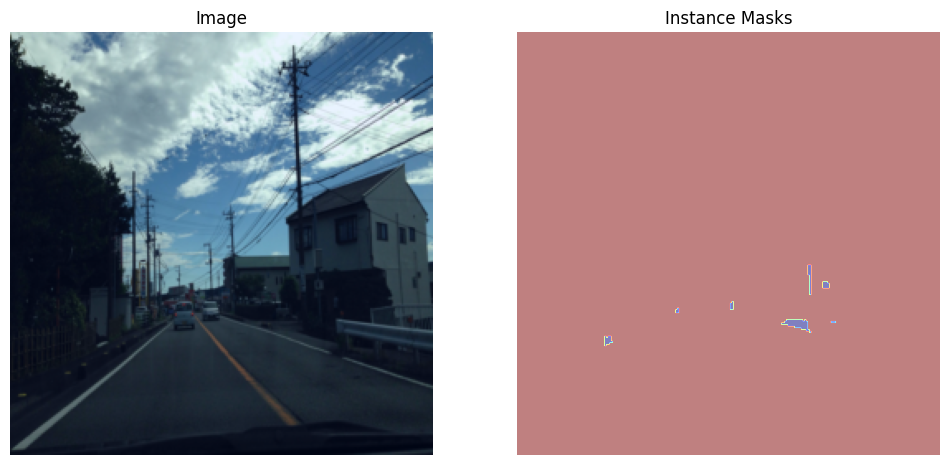

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample(dataset, idx):
    # Get the image and target
    image, target = dataset[idx]

    # Convert the image to NumPy for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Change shape to HxWxC

    # Rescale image to [0, 1] range for visualization
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize

    # Display the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.axis('off')
    plt.title('Image')

    # Display the mask
    masks = target['masks']
    if masks.dim() == 3:  # Check if there are masks
        combined_mask = masks.byte().cpu().numpy().max(axis=0)  # Combine all instance masks
        plt.subplot(1, 2, 2)
        plt.imshow(combined_mask, cmap='jet', alpha=0.5)  # Show the instance masks with color
        plt.axis('off')
        plt.title('Instance Masks')
    else:
        plt.subplot(1, 2, 2)
        plt.imshow(np.zeros_like(image_np[:, :, 0]), cmap='jet', alpha=0.5)  # No masks
        plt.axis('off')
        plt.title('No Masks')

    plt.show()

# Visualize the first sample in the dataset
visualize_sample(dataset, 0)

Number of objects: 255, Masks shape: torch.Size([255, 256, 256])
Raw prediction output: [{'boxes': tensor([[ 20.0393, 119.4706, 247.0947, 226.1081],
        [ 46.5376,  61.1603, 224.9547, 210.5651],
        [ 45.3302, 173.6607, 254.9509, 246.4774],
        [ 20.5187, 173.1711, 167.4050, 234.2529],
        [  3.9400,  17.2864, 239.5290, 160.4712],
        [ 45.5357, 156.5241, 181.9364, 216.3713],
        [ 90.8146, 163.9447, 233.6440, 228.2249],
        [ 91.6697, 136.5956, 232.1030, 194.2607],
        [ 93.6161,  77.5578, 249.8705, 247.6335],
        [ 97.7082,  60.3180, 237.9619, 171.5969],
        [ 86.2329, 173.9712, 178.6647, 240.5781],
        [ 65.7270, 122.8438, 186.1915, 202.0471],
        [  0.9478, 126.7632, 162.1888, 252.5311],
        [112.1419, 181.7296, 218.2473, 254.2316],
        [ 67.4106, 202.8842, 236.4118, 249.6646],
        [ 95.1932, 112.1782, 245.1053, 179.2959],
        [ 38.1128, 190.2847, 150.2427, 217.4116],
        [ 11.9049, 191.1575, 134.6300, 245.8826],
 

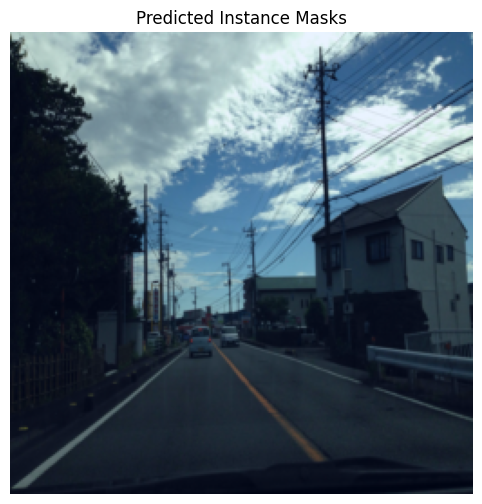

In [ ]:
# Function to visualize predictions
def visualize_predictions(model, dataset, idx, threshold=0.5):
    with torch.no_grad():
        # Get the image and target
        image, _ = dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Make predictions
        prediction = model(image)

        # Debugging: print raw prediction output
        print("Raw prediction output:", prediction)

        # Get predicted masks, boxes, and scores
        masks = prediction[0]['masks']
        boxes = prediction[0]['boxes']
        scores = prediction[0]['scores']

        # Check for non-zero mask values
        for i in range(len(masks)):
            mask_np = masks[i, 0].byte().cpu().numpy()
            print(f"Mask values for object {i}: {np.unique(mask_np)}")

        # Convert image to numpy for visualization
        image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

        plt.figure(figsize=(12, 6))
        plt.imshow(image_np)  # Show the original image
        plt.axis('off')
        plt.title('Predicted Instance Masks')

        # Overlay masks and boxes on the image
        for i in range(len(masks)):
            if scores[i] > threshold:  # Only consider masks with score > threshold
                mask_np = masks[i, 0].byte().cpu().numpy()

                # Only overlay non-zero masks
                if np.any(mask_np):
                    # Create a color for the mask
                    color = np.random.rand(3)  # Random color for each mask
                    plt.imshow(mask_np, alpha=0.5, cmap='jet')  # Overlay mask with transparency

                    # Draw bounding boxes
                    box = boxes[i].cpu().numpy()
                    plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                                        fill=False, color=color, linewidth=2))

        plt.show()

# Visualize predictions for the first sample
visualize_predictions(model, dataset, 0)